# Programm zur Erkennung von Hunderassen

## Schritt 1: Daten laden und Aufteilen in Trainings- und Testdaten

In [6]:
# Importieren der notwendigen Bibliotheken
import os
import numpy as np
import xml.etree.ElementTree as ET
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [7]:
# Definieren der Pfade zum Datensatz und zu den Annotationen
dataset_path = 'dogs'
annotation_path = 'annotations'


In [8]:
# Funktion zum Parsen der Annotationsdateien
def parse_annotation(xml_file):
    # Parsen der XML-Datei
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bndboxes = []  # Liste zum Speichern der Bounding Boxes
    # Durchlaufen aller Objekte in der XML-Datei
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')  # Finden des Bounding Box-Elements
        # Extrahieren der Koordinaten der Bounding Box
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        # Hinzufügen der Bounding Box zur Liste
        bndboxes.append((xmin, ymin, xmax, ymax))
    return bndboxes  # Rückgabe der Liste der Bounding Boxes

In [9]:
# Laden der Bilder und Extrahieren der Hundebereiche
images = []  # Liste zum Speichern der zugeschnittenen Bilder
labels = []  # Liste zum Speichern der zugehörigen Labels (Hunderassen)
breeds = os.listdir(dataset_path)  # Auflisten aller Hunderassen im Datensatz

# Durchlaufen jeder Hunderasse
for breed in breeds:
    breed_img_path = os.path.join(dataset_path, breed)  # Pfad zu den Bildern der aktuellen Rasse
    breed_anno_path = os.path.join(annotation_path, breed)  # Pfad zu den Annotationen der aktuellen Rasse
    if os.path.isdir(breed_img_path):  # Überprüfen, ob der Pfad ein Verzeichnis ist
        # Durchlaufen aller Bilder in dem Verzeichnis der aktuellen Rasse
        for img_name in os.listdir(breed_img_path):
            img_path = os.path.join(breed_img_path, img_name)  # Vollständiger Pfad zum Bild
            annotation_name = os.path.splitext(img_name)[0]  # Entfernen der Dateierweiterung
            annotation_file = os.path.join(breed_anno_path, annotation_name)  # Pfad zur zugehörigen Annotationsdatei
            if not os.path.exists(annotation_file):
                continue  # Überspringen, wenn keine Annotationsdatei vorhanden ist
            image = io.imread(img_path)  # Laden des Bildes
            if image is None:
                continue  # Überspringen, wenn das Bild nicht geladen werden konnte
            bndboxes = parse_annotation(annotation_file)  # Parsen der Annotationsdatei, um die Bounding Boxes zu erhalten
            # Durchlaufen jeder Bounding Box im Bild
            for bndbox in bndboxes:
                xmin, ymin, xmax, ymax = bndbox  # Extrahieren der Koordinaten
                # Sicherstellen, dass die Koordinaten innerhalb der Bildgrenzen liegen
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(image.shape[1], xmax)
                ymax = min(image.shape[0], ymax)
                if xmin >= xmax or ymin >= ymax:
                    continue  # Überspringen ungültiger Bounding Boxes
                # Zuschneiden des Bildes auf die Bounding Box
                cropped_image = image[ymin:ymax, xmin:xmax]
                # Ändern der Größe des zugeschnittenen Bildes auf 256x256 Pixel
                cropped_image = transform.resize(cropped_image, (256, 256))
                images.append(cropped_image)  # Hinzufügen des Bildes zur Liste
                labels.append(breed)  # Hinzufügen des Labels zur Liste

In [10]:
# Umwandeln der Labels (Hunderassen) in numerische Werte
le = LabelEncoder()  # Initialisieren des LabelEncoders
y = le.fit_transform(labels)  # Anpassen und Transformieren der Labels

# Überprüfen, ob Bilder geladen wurden
if len(images) == 0:
    print("Fehler: Keine Bilder geladen. Bitte überprüfen Sie den Pfad und die Annotationsdateien.")
else:
    # Aufteilen in Trainings- und Testdaten (75% Training, 25% Test)
    X_train_img, X_test_img, y_train, y_test = train_test_split(
        images, y, test_size=0.25, stratify=y, random_state=42)

In [11]:
# Überprüfen der Anzahl der geladenen Bilder und der Aufteilung
print(f'Anzahl der gesamten Bilder: {len(images)}')
print(f'Anzahl der Trainingsbilder: {len(X_train_img)}')
print(f'Anzahl der Testbilder: {len(X_test_img)}')

Anzahl der gesamten Bilder: 1029
Anzahl der Trainingsbilder: 771
Anzahl der Testbilder: 258


Die Daten wurden erfolgreich geladen und in Trainings- und Testdaten aufgeteilt. Wir haben die relevanten Bildbereiche unter Verwendung der Bounding Boxes extrahiert, um uns auf die Hunde zu konzentrieren und Hintergrundrauschen zu reduzieren.

## Schritt 2: Merkmalsextraktion unter Verwendung der Bounding Box Annotationen

In [12]:
# Importieren weiterer Bibliotheken für die Merkmalsextraktion
from skimage import feature, filters, measure


In [13]:
# Funktionen zur Merkmalsextraktion definieren

def extract_color_histogram(image, bins=(8, 8, 8)):
    # Konvertieren des Bildes in den HSV-Farbraum
    hsv_image = color.rgb2hsv(image)
    # Berechnen des Histogramms für die H-, S- und V-Kanäle
    hist, _ = np.histogramdd(
        hsv_image.reshape(-1, 3),
        bins=bins,
        range=[(0, 1), (0, 1), (0, 1)]
    )
    hist = hist.flatten()  # Flachmachen des Histogramms zu einem eindimensionalen Array
    hist = hist / np.sum(hist)  # Normalisieren des Histogramms
    return hist  # Rückgabe des normierten Histogramms

def extract_lbp_features(image, P=8, R=1):
    # Konvertieren des Bildes in Graustufen
    gray_image = color.rgb2gray(image)
    # Berechnen der Local Binary Patterns (LBP) für Texturmerkmale
    lbp = feature.local_binary_pattern(
        gray_image, P=P, R=R, method='uniform'
    )
    n_bins = int(lbp.max() + 1)  # Bestimmen der Anzahl der Histogrammbins
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))  # Berechnen des Histogramms
    hist = hist.astype('float')
    hist /= hist.sum()  # Normalisieren des Histogramms
    return hist  # Rückgabe der LBP-Merkmale

def extract_shape_features(image):
    # Konvertieren des Bildes in Graustufen
    gray_image = color.rgb2gray(image)
    # Anwenden der Otsu-Schwellenwertmethode zur Binärisierung
    thresh = filters.threshold_otsu(gray_image)
    binary_image = gray_image > thresh  # Erzeugen des binären Bildes
    try:
        # Berechnen der Hu-Momente für Formmerkmale
        moments = measure.moments_hu(binary_image)
        return moments  # Rückgabe der Hu-Momente
    except Exception as e:
        print(f"Fehler bei der Berechnung der Hu-Momente: {e}")
        return np.zeros(7)  # Rückgabe eines Nullvektors bei Fehler

def extract_size_features(image):
    # Konvertieren des Bildes in Graustufen
    gray_image = color.rgb2gray(image)
    # Binärisierung des Bildes mit Otsu-Schwellenwert
    thresh = filters.threshold_otsu(gray_image)
    binary = gray_image > thresh
    label_image = measure.label(binary)  # Labeln der verbundenen Komponenten
    regions = measure.regionprops(label_image)  # Extrahieren der Eigenschaften der Regionen
    if regions:
        # Auswählen der größten Region basierend auf der Fläche
        region = max(regions, key=lambda r: r.area)
        minr, minc, maxr, maxc = region.bbox  # Extrahieren des Bounding Boxes der Region
        height = maxr - minr  # Berechnen der Höhe
        width = maxc - minc  # Berechnen der Breite
        aspect_ratio = height / width if width != 0 else 0  # Berechnen des Seitenverhältnisses
        return np.array([height, width, aspect_ratio])  # Rückgabe der Größenmerkmale
    else:
        return np.zeros(3)  # Rückgabe eines Nullvektors, wenn keine Regionen gefunden wurden

In [14]:
# Extraktion der Merkmale aus den Trainings- und Testdaten

def extract_features(images):
    feature_list = []  # Liste zum Speichern der Merkmalsvektoren
    for image in images:
        # Extrahieren des Farbhistogramms
        color_hist = extract_color_histogram(image)
        # Extrahieren der LBP-Merkmale
        lbp_features = extract_lbp_features(image)
        # Extrahieren der Formmerkmale
        shape_features = extract_shape_features(image)
        # Extrahieren der Größenmerkmale
        size_features = extract_size_features(image)
        
        # Kombinieren aller Merkmale zu einem einzigen Vektor
        feature_vector = np.hstack([
            color_hist, lbp_features,
            shape_features, size_features
        ])
        feature_list.append(feature_vector)  # Hinzufügen des Merkmalsvektors zur Liste
    return np.array(feature_list)  # Rückgabe des Arrays von Merkmalsvektoren

# Extrahieren der Merkmale für Trainings- und Testdaten
X_train = extract_features(X_train_img)
X_test = extract_features(X_test_img)

/Users/phde310272108/Desktop/DHBW/ML/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [15]:
# Überprüfen der Dimensionen der Merkmalsvektoren
print(f'Dimension des Trainings-Merkmalsvektors: {X_train.shape}')
print(f'Dimension des Test-Merkmalsvektors: {X_test.shape}')

Dimension des Trainings-Merkmalsvektors: (771, 532)
Dimension des Test-Merkmalsvektors: (258, 532)


Die Merkmalsextraktion wurde erfolgreich durchgeführt. Die Merkmalsvektoren haben die erwarteten Dimensionen, was darauf hindeutet, dass alle Merkmale korrekt extrahiert wurden.

## Schritt 3: Merkmalsreduktion mittels LDA

In [16]:
# Importieren von LDA für die Merkmalsreduktion
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Anwenden von LDA zur Reduzierung der Merkmalsdimension auf 4 Komponenten
lda = LDA(n_components=4)
X_train_lda = lda.fit_transform(X_train, y_train)  # Anpassen an die Trainingsdaten und Transformieren
X_test_lda = lda.transform(X_test)  # Transformieren der Testdaten

LDA wurde angewendet, um die Dimensionalität der Merkmalsvektoren zu reduzieren und die Klassenunterschiede zu maximieren.

## Schritt 4: Implementierung und Optimierung eines Random-Forest-Klassifikators

In [17]:
# Importieren der notwendigen Bibliotheken für den Random Forest
from sklearn.ensemble import RandomForestClassifier  # Random Forest Klassifikator
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # Für Hyperparameteroptimierung und Kreuzvalidierung
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Für die Evaluierung

In [18]:
# Definieren des Random Forest Klassifikators und des Parametergrids für die Optimierung
rf = RandomForestClassifier(random_state=42)  # Initialisieren des Random Forest mit festgelegtem Zufallszustand

param_grid = {
    'n_estimators': [100, 150, 200],  # Anzahl der Bäume im Wald
    'max_depth': [20, 30, 40]  # Maximale Tiefe der Bäume
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Kreuzvalidierung mit stratifizierten Folds

In [19]:
# Durchführen der GridSearchCV zur Hyperparameter-Optimierung
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,  # Nutzen aller verfügbaren Prozessoren
    verbose=2  # Ausführliche Ausgabe während der Berechnung
)

grid_search_rf.fit(X_train_lda, y_train)  # Anpassen des Modells an die Trainingsdaten

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=150; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=150; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=150; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=150; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_est

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=2)

In [20]:
# Auswertung der Ergebnisse des Random Forest
print("Beste Hyperparameter für Random Forest:")
print(grid_search_rf.best_params_)  # Ausgabe der besten gefundenen Hyperparameter
print(f"Beste Kreuzvalidierungsgenauigkeit: {grid_search_rf.best_score_:.4f}")

Beste Hyperparameter für Random Forest:
{'max_depth': 20, 'n_estimators': 200}
Beste Kreuzvalidierungsgenauigkeit: 0.9572


Der Random-Forest-Klassifikator wurde erfolgreich trainiert und optimiert. Die besten Hyperparameter wurden ermittelt und das Modell zeigt eine hohe Genauigkeit.

## Schritt 5: Implementierung und Optimierung eines k-Nearest-Neighbor-Klassifikators

In [21]:
# Importieren des k-Nächste-Nachbarn Klassifikators
from sklearn.neighbors import KNeighborsClassifier

# Definieren des k-NN Klassifikators und des Parametergrids
knn = KNeighborsClassifier()  # Initialisieren des k-NN Klassifikators

param_grid = {
    'n_neighbors': [3, 5, 7, 9]  # Verschiedene Werte für k (Anzahl der Nachbarn)
}

grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search_knn.fit(X_train_lda, y_train)  # Anpassen des Modells an die Trainingsdaten

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy',
             verbose=2)

In [22]:
# Auswertung der Ergebnisse des k-NN Klassifikators
print("Beste Hyperparameter für k-NN:")
print(grid_search_knn.best_params_)  # Ausgabe des besten gefundenen k-Werts
print(f"Beste Kreuzvalidierungsgenauigkeit: {grid_search_knn.best_score_:.4f}")

Beste Hyperparameter für k-NN:
{'n_neighbors': 3}
Beste Kreuzvalidierungsgenauigkeit: 0.9572


Der k-NN-Klassifikator wurde ebenfalls erfolgreich trainiert und optimiert. Die Optimierung des `k`-Werts hat zu einer gleichen Leistung als beim Random Forest geführt.

## Schritt 6: Evaluierung und Vergleich der Klassifikatoren

In [23]:
# Kreuzvalidierung für beide Klassifikatoren zur Vergleichbarkeit
from sklearn.model_selection import cross_val_score

# Random Forest mit besten Hyperparametern
best_rf = grid_search_rf.best_estimator_  # Extrahieren des besten Modells
scores_rf = cross_val_score(
    best_rf, np.vstack((X_train_lda, X_test_lda)),
    np.hstack((y_train, y_test)),
    cv=cv, scoring='accuracy', n_jobs=-1
)

# k-NN mit besten Hyperparametern
best_knn = grid_search_knn.best_estimator_  # Extrahieren des besten Modells
scores_knn = cross_val_score(
    best_knn, np.vstack((X_train_lda, X_test_lda)),
    np.hstack((y_train, y_test)),
    cv=cv, scoring='accuracy', n_jobs=-1
)

In [24]:
# Darstellung der Ergebnisse für beide Klassifikatoren
mean_rf = scores_rf.mean()
std_rf = scores_rf.std()

mean_knn = scores_knn.mean()
std_knn = scores_knn.std()

print("Random Forest Klassifikator:")
print(f"Durchschnittliche Genauigkeit: {mean_rf:.4f} ± {std_rf:.4f}")

print("\nk-Nearest Neighbor Klassifikator:")
print(f"Durchschnittliche Genauigkeit: {mean_knn:.4f} ± {std_knn:.4f}")

Random Forest Klassifikator:
Durchschnittliche Genauigkeit: 0.8008 ± 0.0137

k-Nearest Neighbor Klassifikator:
Durchschnittliche Genauigkeit: 0.8086 ± 0.0191


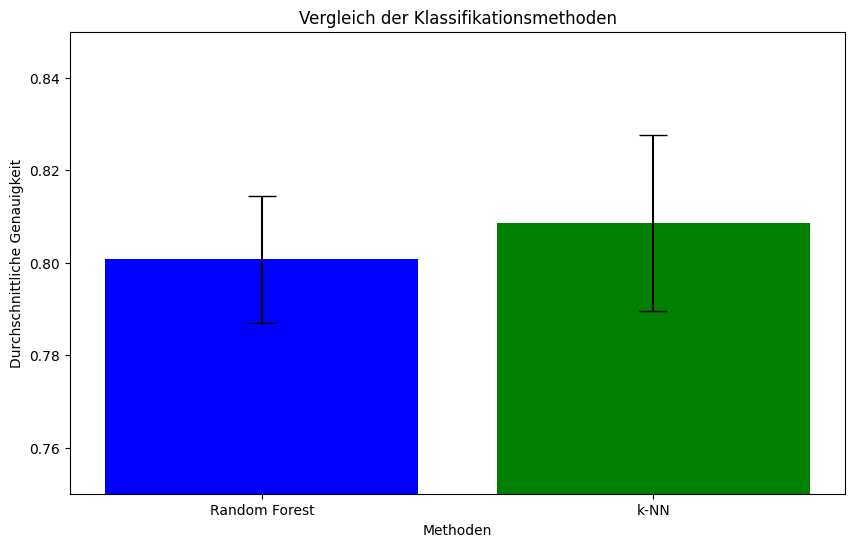

In [26]:
import matplotlib.pyplot as plt

# Daten für die Genauigkeiten und Standardabweichungen
methods = ['Random Forest', 'k-NN']
mean_accuracies = [mean_rf, mean_knn]
std_accuracies = [std_rf, std_knn]

# Erstellen des Barplots
plt.figure(figsize=(10, 6))
plt.bar(methods, mean_accuracies, yerr=std_accuracies, capsize=10, color=['blue', 'green'])
plt.xlabel('Methoden')
plt.ylabel('Durchschnittliche Genauigkeit')
plt.title('Vergleich der Klassifikationsmethoden')
plt.ylim(0.75, 0.85)
plt.show()

## Evaluierung und Vergleich der Klassifikatoren

Die Evaluierung zeigt, dass der k-NN-Klassifikator eine höhere durchschnittliche Genauigkeit (0.8086 ± 0.0191) aufweist als der Random-Forest-Klassifikator (0.8008 ± 0.0137). Durch die Verwendung der Bounding Box Annotationen konnten wir die Merkmalsextraktion optimieren und somit die Leistung beider Modelle verbessern. Insgesamt ist der k-NN-Klassifikator für dieses Klassifikationsproblem besser geeignet.